# Primary and Secondary Hand

For understanding the code in detail, please refer to the  [PD_classification_Kamble](PD_classification_Kamble.ipynb) notebook.

We used the Dataset from Studium.

In [1]:
# import module
from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.morphology import skeletonize
from numba.typed import List
from utils import thin_spiral_image_with_custom_cut, find_spiral_point, \
         trace_spiral, get_angle_dist2, angle_cont_func, plt_traced
from scipy import signal
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.ndimage import gaussian_filter1d

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

import random

In [2]:

# Store Pdf with convert_from_path function
#images = convert_from_path(r'C:\Users\Baumann\Documents\UU\03_semester\AIA\project\new_data\left-right-spirals.pdf')
images = convert_from_path(r'/Users/linusfalk/Dev/AIA/AIA/left-right-spirals.pdf')


In [3]:
df = {}
iterations = [60, 640, 1170, 1730, 2400]
left_right = [200, 800, 1500]
for i in range(len(images)):
    for rl in range(2):
        for it in range(4):
            df['p{:02}_{}_{}'.format(i, rl, it)] = np.array(images[i])[iterations[it]:iterations[it+1], left_right[rl]:left_right[rl+1]]


p00_0_0


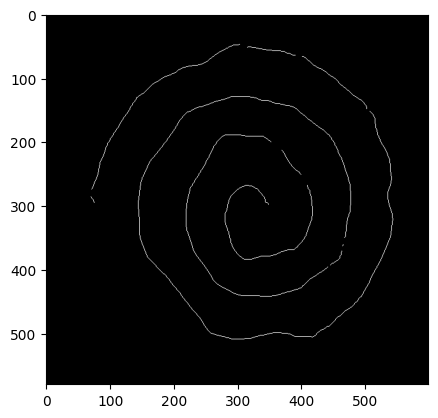

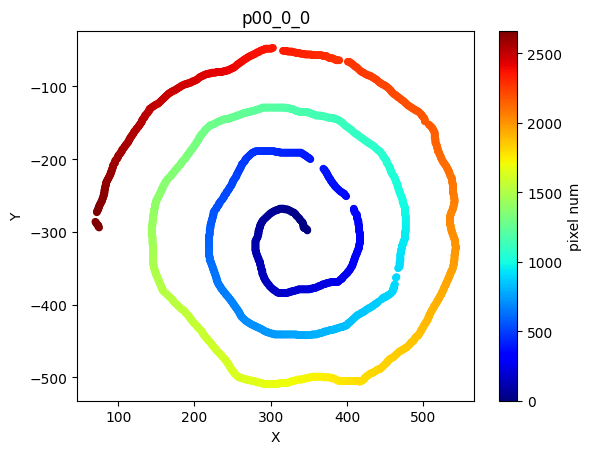

p00_0_1
p00_0_2
p00_0_3
p00_1_0
p00_1_1
p00_1_2
p00_1_3
p01_0_0
p01_0_1
p01_0_2
p01_0_3
p01_1_0
p01_1_1
p01_1_2
p01_1_3
p02_0_0
p02_0_1
p02_0_2
p02_0_3
p02_1_0
p02_1_1
p02_1_2
p02_1_3
p03_0_0
p03_0_1
p03_0_2
p03_0_3
p03_1_0
p03_1_1
p03_1_2
p03_1_3
p04_0_0
p04_0_1
p04_0_2
p04_0_3
p04_1_0
p04_1_1
p04_1_2
p04_1_3
p05_0_0
p05_0_1
p05_0_2
p05_0_3
p05_1_0
p05_1_1
p05_1_2
p05_1_3
p06_0_0
p06_0_1
p06_0_2
p06_0_3
p06_1_0
p06_1_1
p06_1_2
p06_1_3
p07_0_0
p07_0_1
p07_0_2
p07_0_3
p07_1_0
p07_1_1
p07_1_2
p07_1_3
p08_0_0
p08_0_1
p08_0_2
p08_0_3
p08_1_0
p08_1_1
p08_1_2
p08_1_3
p09_0_0
p09_0_1
p09_0_2
p09_0_3
p09_1_0
p09_1_1
p09_1_2
p09_1_3
p10_0_0
p10_0_1
p10_0_2
p10_0_3
p10_1_0
p10_1_1
p10_1_2
p10_1_3


In [4]:
names = []
trace_distances_all = []
trace_angle_all = []
all_paths = []
first = True

for name in df:
    print(name)
    # the red color threshold should not be hardcoded
    tmp = np.array((df[name] < [190, 0, 0]) * 255, dtype=np.uint16)
    #print(tmp.shape)
    tmp = cv2.cvtColor(tmp, cv2.COLOR_RGB2GRAY)
    _, tmp = cv2.threshold(tmp, 50, 255, cv2.THRESH_BINARY)
    
    kernel = np.ones((2,2),np.uint8)
    tmp = cv2.morphologyEx(tmp, cv2.MORPH_OPEN, kernel)
    
    kernel = np.ones((3,3),np.uint8)
    tmp = cv2.dilate(tmp,kernel,iterations = 1)
    
    kernel = np.ones((5,5),np.uint8)
    tmp = cv2.morphologyEx(tmp, cv2.MORPH_CLOSE, kernel)
    
    tmp = skeletonize(tmp)
    skeleton_img_cropped = np.array(tmp*1, np.uint8)
    # find center/start_point of the spiral
    spiral_start = find_spiral_point(skeleton_img_cropped, point=(0, 0), first=True, search_radius=200)
    if not spiral_start:
        print('not possible to extract')
        plt.imshow(img)
        plt.show()
        continue
    # follow the start point through the spiral
    skeleton_img_trace = skeleton_img_cropped.copy()
    trace_path = trace_spiral(skeleton_img_trace, spiral_start, search_radius=70, neigbor=False, flipped_priority=True) #, search_radius=200)
    trace_path_typed = List()
    [trace_path_typed.append(i) for i in trace_path]

    # turn the coordinates in angle and distance for an alternative representation
    trace_angle, trace_distances = get_angle_dist2(trace_path_typed)
    
    trace_angle_all.append(trace_angle)
    trace_distances_all.append(trace_distances)
    names.append(name)
    all_paths.append(trace_path)

    if first:
        plt.imshow(tmp, 'grey')
        plt.show()
        plt_traced(trace_path, name)
    first = False

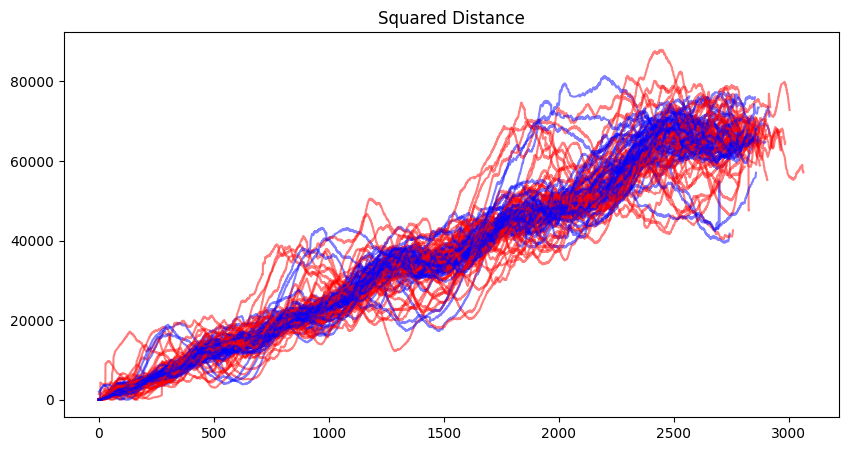

In [5]:
df = {}

plt.figure(figsize=(10, 5))
for d2, name in zip(trace_distances_all, names):
    df[name] = {}
    if True: #not 'dynamic' in name:
        x = np.array([k for k in range(len(d2))]).reshape((-1, 1))
        reg = LinearRegression().fit(x, d2)
        pred = reg.predict(x)
        pad = 0
        d2 = list([0.0 for _ in range(pad)]) + list(d2)
        #print(d2)
        filtered = gaussian_filter1d(d2, 160)[pad:]
        filtered2 = gaussian_filter1d(d2, 30)[pad:]
        filtered3 = gaussian_filter1d(d2, 5)[pad:]
        d2 = d2[pad:]
        
        color = 'red' if name[4]=='0' else 'blue'
        plt.plot(d2[:], c=color, alpha=0.5)
        #plt.plot(pred, c='k')
        #plt.plot(filtered2, c='lightgrey')

        df[name]['dist2'] = d2
        df[name]['dist2_linreg'] = pred
        df[name]['dist2_filtered'] = filtered
        df[name]['dist2_filtered2'] = filtered2
        df[name]['dist2_filtered3'] = filtered3
        
plt.title('Squared Distance')
plt.show()

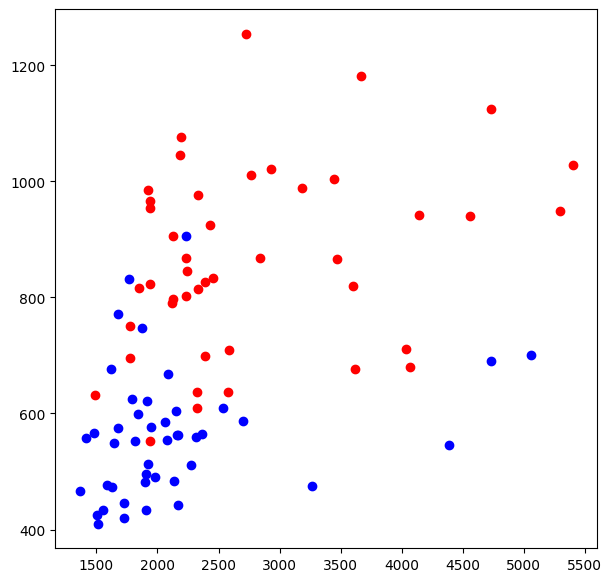

In [6]:
plt.figure(figsize=(7,7))
for name in df:
    if True:
        sa, ea = 10, -5
        sd, ed = 10, -5
        c = 'red' if name[4]=='0' else 'blue'
        x = np.std([i-j for i, j in zip(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])])
        y = np.std([i-j for i, j in zip(df[name]['dist2'][sa:ea], df[name]['dist2_filtered2'][sa:ea])])
        #y = df[name]['inter']
        #y = df[name]['slope']
        
        #y = np.std([i-j for i, j in zip(df[name]['rad'][50:-50], df[name]['rad_filtered'][50:-50])])
        #y = np.std(df[name]['angle_alt'][50:-50])
        
        plt.scatter(x, y, c=c)
        #plt.text(x*1.01, y*1.01, name[:3], fontsize=7)
#plt.xlim((1000, 4000))
#plt.ylim((300, 2000))
plt.show()

In [7]:
X_train, X_test = [], []
y_train, y_test = [], []

for b in [True, False]:
    tmpX, tmpy = [], []
    df_rand = list(df.keys())
    random.seed(31415)
    random.shuffle(df_rand) #TODO random split is bad, we should take patient ID into account 
    for name in df_rand:
        if True: #len(df[name]['dist2']) > 800:
            if ((name[4]=='0') == b):
                sa, ea = 10, -5
                sd, ed = 10, -5
                lbl = 1 if name[4]=='0' else 0
                x = np.std([i-j for i, j in zip(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])])
                y = np.std([i-j for i, j in zip(df[name]['dist2'][sa:ea], df[name]['dist2_filtered2'][sa:ea])])
                tmpX.append([x, y])
                tmpy.append(lbl)
    
    X_test.extend(tmpX[-len(tmpX)//3:])
    X_train.extend(tmpX[:-len(tmpX)//3])
    y_test.extend(tmpy[-len(tmpy)//3:])
    y_train.extend(tmpy[:-len(tmpy)//3])

In [8]:
clf = LinearDiscriminantAnalysis()

clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)

acc_test = 100 * (cm_test[0, 0] + cm_test[1, 1]) / sum(sum(cm_test))
print(f'test accuracy: {acc_test:.2f}%')

[[14  1]
 [ 2 13]]
test accuracy: 90.00%


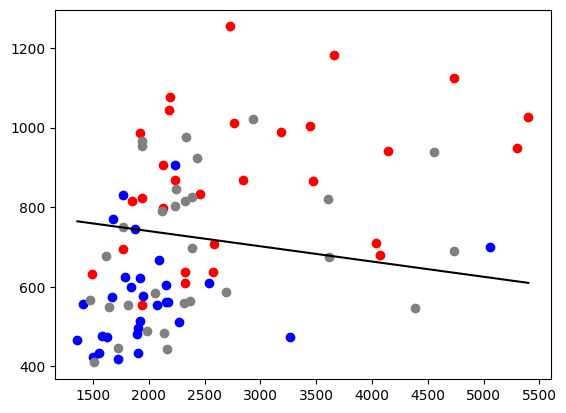

In [9]:
for X, y in zip(X_train, y_train):
    plt.scatter(X[0], X[1], c=['blue', 'red'][y])
for X in X_test:
    plt.scatter(X[0], X[1], c='grey')

plt.plot([min(np.array(X_train)[:, 0]), max(np.array(X_train)[:, 0])], [-(clf.intercept_ + min(np.array(X_train)[:, 0])*clf.coef_[0, 0])/clf.coef_[0, 1], -(clf.intercept_ + max(np.array(X_train)[:, 0])*clf.coef_[0, 0])/clf.coef_[0, 1]], 'k')
#plt.xscale('log')
#plt.yscale('log')

### k-fold cross validation taking groups into account

(array([1., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1.]),
 array([0.5625  , 0.584375, 0.60625 , 0.628125, 0.65    , 0.671875,
        0.69375 , 0.715625, 0.7375  , 0.759375, 0.78125 , 0.803125,
        0.825   , 0.846875, 0.86875 , 0.890625, 0.9125  , 0.934375,
        0.95625 , 0.978125, 1.      ]),
 <BarContainer object of 20 artists>)

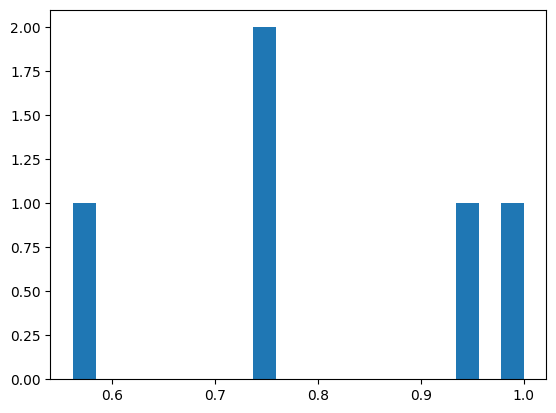

In [10]:


from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.utils import shuffle




# Create lists for splitting with groups, makes sure that same patient doesnt end up in train and test set
primary = []
secondary = []
groups_primary = []
groups_secondary = []
for name in df:
       if name[4]=='0':
               primary.append(name)
               groups_primary.append(name[:3])
       else:
               secondary.append(name)
               groups_secondary.append(name[:3])


X = np.array(primary + secondary)
Y = np.array([1] * len(primary) + [0] * len(secondary))
groups = np.array(groups_primary + groups_secondary)

# Number of folds
k = 5

# List to store metrics for each fold
accuracies = []
precisions = []
recalls = []
f1_scores = []


# Create the model
model = LogisticRegression()


# Create k-fold cross-validation object
gkf = GroupKFold(n_splits=k)  # Splits the data into 5 folds


for train_index, test_index in gkf.split(X, Y, groups):     # Split data into training and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        X_train_data = []
        X_test_data = []

        for name in X_train:
                x = np.std([i-j for i, j in zip(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])])
                y = np.std([i-j for i, j in zip(df[name]['dist2'][sa:ea], df[name]['dist2_filtered2'][sa:ea])])
                X_train_data.append([x, y])
              
        for name in X_test:
                x = np.std([i-j for i, j in zip(df[name]['dist2'][sd:ed], df[name]['dist2_filtered'][sd:ed])])
                y = np.std([i-j for i, j in zip(df[name]['dist2'][sa:ea], df[name]['dist2_filtered2'][sa:ea])])
                X_test_data.append([x, y])


              
        # Fit the model
        model.fit(X_train_data, y_train)


        # Predict on the test set
        y_pred = model.predict(X_test_data)
        y_pred_prob = model.predict_proba(X_test_data)


        # Calculate and store the results
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))



plt.hist(accuracies, bins=20)



In [11]:
print('accuracies   mean: ', round(np.mean(accuracies), 4), ';  std:  ', np.std(accuracies))
print('precisions   mean: ', round(np.mean(precisions), 4), ';  std:  ', np.std(precisions))
print('recalls      mean: ', round(np.mean(recalls), 4), ';  std:  ', np.std(recalls))
print('f1_scores    mean: ', round(np.mean(f1_scores), 4), ';  std:  ', np.std(f1_scores))

for i in [accuracies, precisions, recalls, f1_scores]:
    print(round(np.std(i)*100, 1), end='')
    print('& ', end='')

accuracies   mean:  0.8 ;  std:   0.1551209205748857
precisions   mean:  0.8567 ;  std:   0.18844392033470095
recalls      mean:  0.825 ;  std:   0.18708286933869706
f1_scores    mean:  0.8091 ;  std:   0.13306179028408713
15.5& 18.8& 18.7& 13.3& 

[1.45157593e-01 9.40551264e-01 8.03969636e-01 2.10186692e-01
 5.74587588e-04 1.82838714e-01 1.37614945e-01 2.78299620e-02
 3.66595603e-02 9.87684982e-01 9.73955523e-01 9.91890022e-01
 8.44934621e-01 6.12764688e-02 9.67803073e-01 8.88719921e-01]


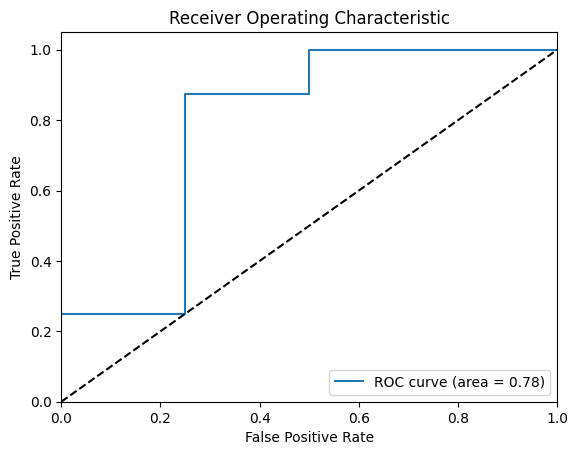

In [12]:
print(y_pred_prob[:,0])
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1]) # y_pred_prob is the probability of the positive class
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

